In [1]:
import torch

# 正向传播
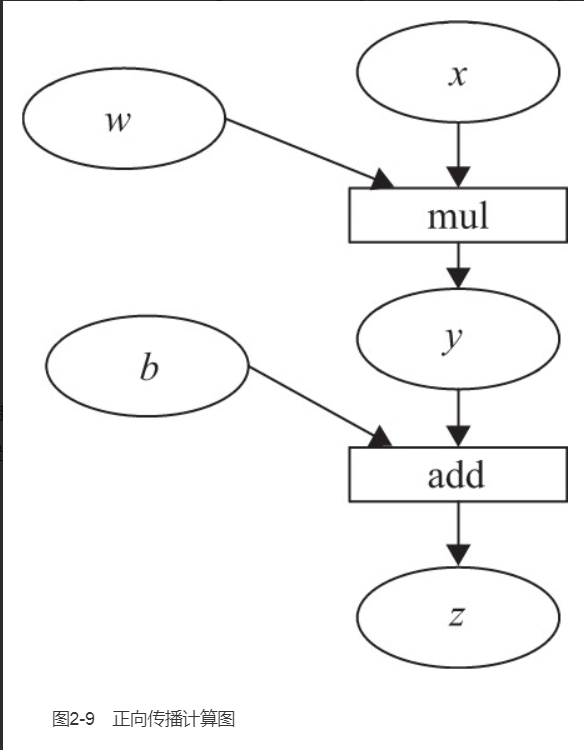
# 反向传播
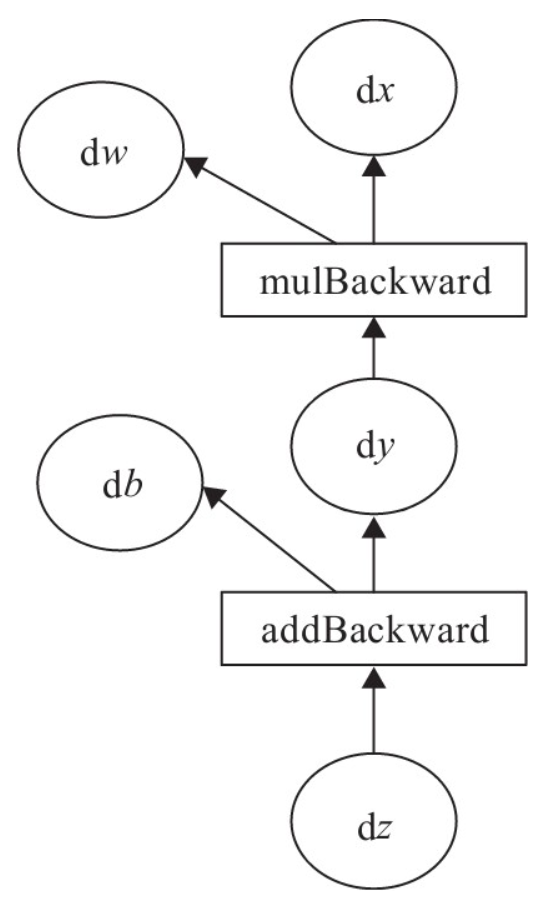
# 梯度
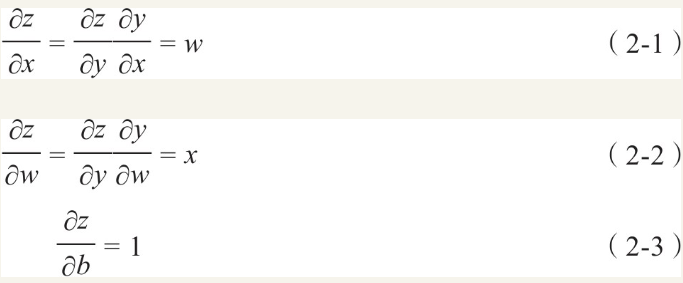

# 梯度计算相关参数

1）创建叶子节点（Leaf Node）的Tensor，使用requires_grad参数指定是否记录对其的操作，以便之后利用backward()方法进行梯度求解。requires_grad参数的缺省值为False，如果要对其求导需设置为True，然后与之有依赖关系的节点会自动变为True。

2）可利用requires_grad_()方法修改Tensor的requires_grad属性。可以调用.detach()或with torch.no_grad()：，将不再计算张量的梯度，跟踪张量的历史记录。这点在评估模型、测试模型阶段中常常用到。
3）通过运算创建的Tensor（即非叶子节点），会自动被赋予grad_fn属性。该属性表示梯度函数。叶子节点的grad_fn为None。

4）最后得到的Tensor执行backward()函数，此时自动计算各变量的梯度，并将累加结果保存到grad属性中。计算完成后，非叶子节点的梯度自动释放。

5）backward()函数接收参数，该参数应和调用backward()函数的Tensor的维度相同，或者是可broadcast的维度。如果求导的Tensor为标量（即一个数字），则backward中的参数可省略。

6）反向传播的中间缓存会被清空，如果需要进行多次反向传播，需要指定backward中的参数retain_graph=True。多次反向传播时，梯度是累加的。

7）非叶子节点的梯度backward调用后即被清空。

8）可以通过用torch.no_grad()包裹代码块的形式来阻止autograd去跟踪那些标记为.requesgrad=True的张量的历史记录。这步在测试阶段经常使用。

#### backward(gradient=None, retain_graph=None, create_graph=False)
#### gradient：用于张量梯度计算。
#### retain_graph：是否需要重复梯度计算。

In [15]:
# z=wx+b

#定义输入张量x
x=torch.Tensor([2])
#初始化权重参数W,偏移量b、并设置require_grad属性为True, 为自动求导
w=torch.randn(1,requires_grad=True)
b=torch.randn(1,requires_grad=True)

#实现前向传播
y=torch.mul(w,x)  #等价于w*x
z=torch.add(y,b)  #等价于y+b

#查看x,w, b叶子节点的requite_grad属性
print("x,w,b的require_grad属性分别为：{},{},{}"
      .format(x.requires_grad,w.requires_grad,b.requires_grad))
#查看非叶子节点的requres_grad属性,(因为y，z与w,b有依赖关系)
print("y, z的requires_grad属性分别为：{},{}".format(y.requires_grad,z.requires_grad))

x,w,b的require_grad属性分别为：False,True,True
y, z的requires_grad属性分别为：True,True


In [16]:
print("x, w, b, y, z的是否为叶子节点：{},{},{},{},{}"
      .format(x.is_leaf,w.is_leaf,b.is_leaf,y.is_leaf,z.is_leaf))

x, w, b, y, z的是否为叶子节点：True,True,True,False,False


In [17]:
#通过运算创建的Tensor（即非叶子节点），会自动被赋予grad_fn属性。
#该属性表示梯度函数。叶子节点的grad_fn为None。


#查看叶子节点的grad_fn属性
print("x, w, b的grad_fn属性：{},{},{}".format(x.grad_fn,w.grad_fn,b.grad_fn))
#因x, w, b为用户创建的, 为通过其他张量计算得到, 故x, w, b的grad_fn属性：None,None,None


#查看非叶子节点的grad_fn属性
print("y, z的grad_fn属性：{},{}".format(y.grad_fn,z.grad_fn))

x, w, b的grad_fn属性：None,None,None
y, z的grad_fn属性：<MulBackward0 object at 0x0000005096E26B08>,<AddBackward0 object at 0x0000005096E26B88>


In [18]:
#基于z张量进行梯度反向传播,执行backward之后计算图会自动清空, 
z.backward()
#如果需要多次使用backward, 需要修改参数retain_graph为True, 此时梯度是累加的
#z.backward(retain_graph=True)

#查看叶子节点的梯度, x是叶子节点但它无须求导, 故其梯度为None
print("参数w,b的梯度分别为:{},{},{}".format(w.grad,b.grad,x.grad))
#参数w,b的梯度分别为:tensor([2.]),tensor([1.]),None

#非叶子节点的梯度, 执行backward之后, 会自动清空
print("非叶子节点y,z的梯度分别为:{},{}".format(y.grad,z.grad))
#非叶子节点y,z的梯度分别为:None,None

参数w,b的梯度分别为:tensor([2.]),tensor([1.]),None
非叶子节点y,z的梯度分别为:None,None


# 非标量反向传播

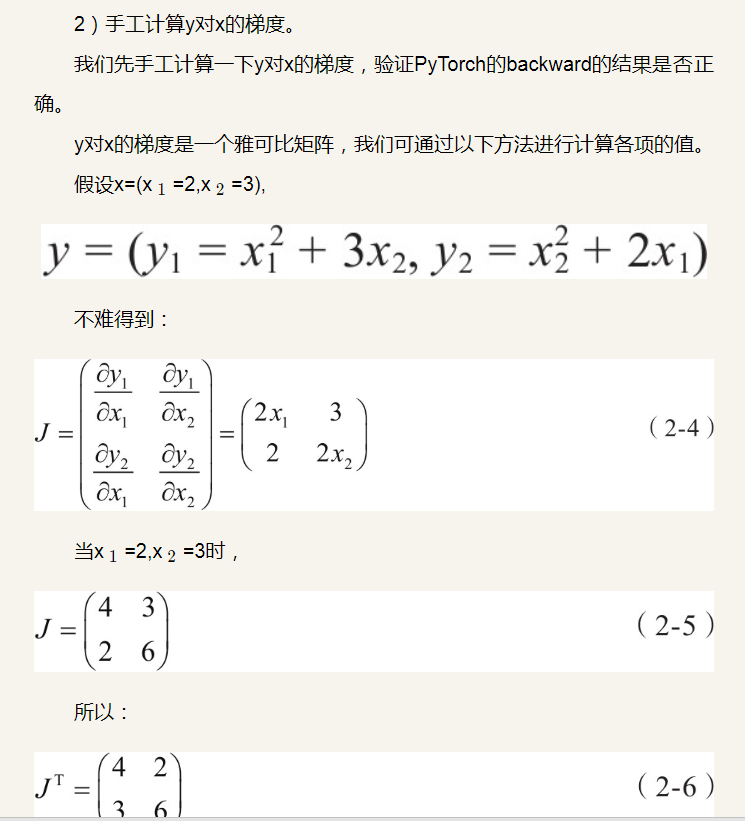

In [28]:
#定义叶子节点张量x, 形状为1x2
x= torch.tensor([[2, 3]], dtype=torch.float, requires_grad=True)
#初始化Jacobian矩阵
J= torch.zeros(2 ,2)
#初始化目标张量, 形状为1x2
y = torch.zeros(1, 2)
#定义y与x之间的映射关系：
#y1=x1**2+3*x2, y2=x2**2+2*x1
y[0, 0] = x[0, 0] ** 2 + 3 * x[0 ,1]
y[0, 1] = x[0, 1] ** 2 + 2 * x[0, 0]

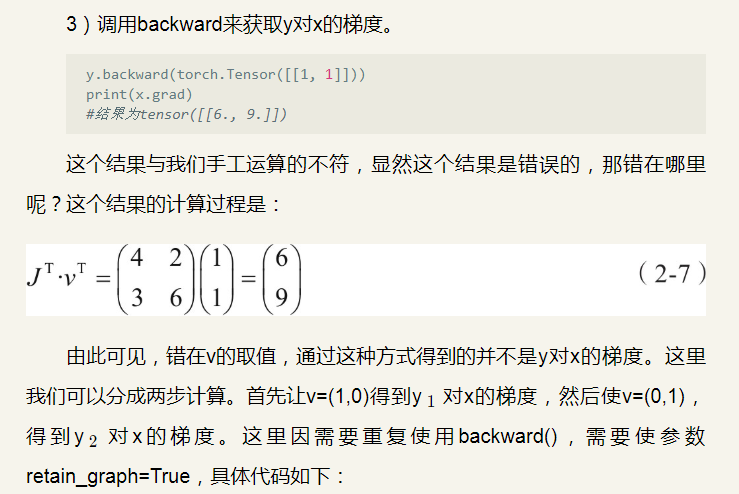

In [22]:
#生成y1对x的梯度
y.backward(torch.Tensor([[1, 0]]),retain_graph=True)
J[0]=x.grad
#梯度是累加的, 故需要对x的梯度清零
x.grad = torch.zeros_like(x.grad)
#生成y2对x的梯度
y.backward(torch.Tensor([[0, 1]]))
J[1]=x.grad
#显示jacobian矩阵的值
print(J)

 #生成y1对x的梯度
y.backward(torch.Tensor([[1, 0]]),retain_graph=True)
J[0]=x.grad
#梯度是累加的, 故需要对x的梯度清零
x.grad = torch.zeros_like(x.grad)
#生成y2对x的梯度
y.backward(torch.Tensor([[0, 1]]))
J[1]=x.grad
#显示jacobian矩阵的值
print(J)

tensor([[4., 3.]])


# 应用

In [1]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt

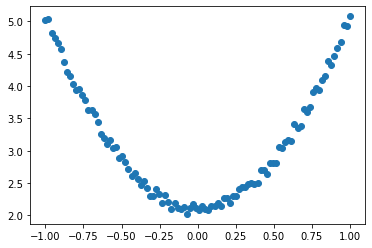

In [8]:
t.manual_seed(100)
dtype = t.float
x = t.unsqueeze(t.linspace(-1,1,100),dim=1)
y = 3*x**2 +2+ 0.2*t.rand(x.size())

plt.scatter(x.numpy(), y.numpy())
plt.show()

In [12]:
# 初始化
w1 = t.randn(1,1, dtype=dtype,requires_grad=True)
b1 = t.zeros(1,1, dtype=dtype, requires_grad=True) 

In [48]:
lr = 0.001 #学习率

for i in range(800):
    y_pred = w1*x**2 + b1
    loss = (0.5*(y_pred-y)**2 ).sum()
    
    grad_w = t.sum((y_pred-y)*x**2)
    grad_b = t.sum((y_pred-y))
    
    w1 = w1 - lr*grad_w
    b1 = b1 - lr*grad_b

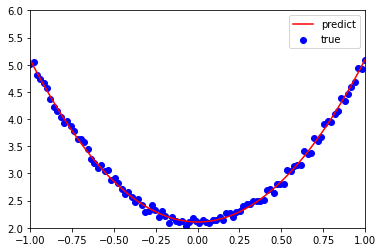

In [52]:
# 求导的变量无法用numpy()?

plt.plot(x, y_pred.detach().numpy(),'r-',label='predict')
plt.scatter(x, y.detach().numpy(),color='blue',marker='o',label='true') # true data
plt.xlim(-1,1)
plt.ylim(2,6)  
plt.legend()
plt.show()

In [49]:
print(w1,b1)

tensor([[2.9853]], grad_fn=<SubBackward0>) tensor([[2.1070]], grad_fn=<SubBackward0>)
